In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.13.0+cpu
using device: cpu


In [8]:
# brain-mri-images-for-brain-tumor-detection
import requests
import zipfile
from pathlib import Path
import os

# Setup path to data folder
data_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")

for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'.
There are 0 directories and 98 images in '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no'.
There are 0 directories and 155 images in '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes'.


In [9]:
no_path = data_path/'no'
yes_path = data_path/'yes'


Random image path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y53.jpg
Image class: Y53
Image height: 219
Image width: 230


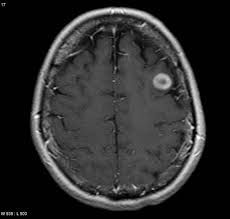

In [14]:
import random
from PIL import Image

# Set seed
random.seed(6) # <- try changing this and see what happens
image_path_list = list(data_path.glob("*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.stem
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

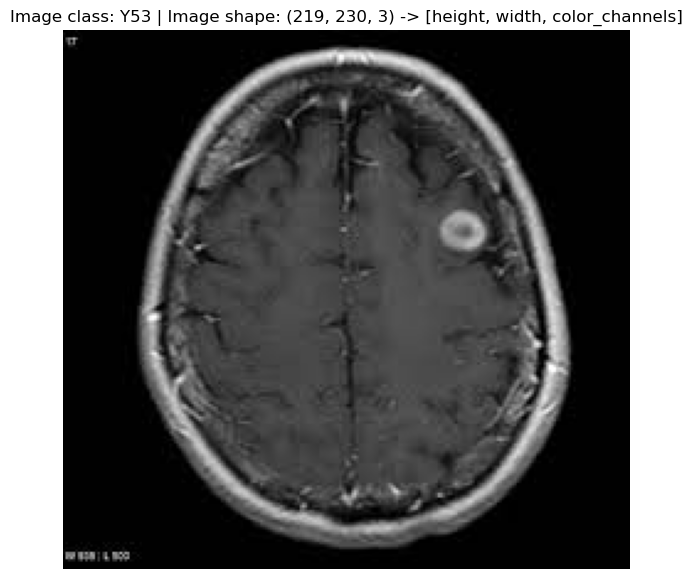

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [176]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List



# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        #removing paths with 4 colour channels i.e. (454, 442, 4), (there is 5 such examples)
        for path in self.paths:
            img = Image.open(path) 
            size = np.asarray(img).shape
            if len(size) >= 3 and size[-1] > 3:
                self.paths.remove(path)
        
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = ['yes', 'no'], {'yes': 1, 'no': 0}

    # 4. Make function to load images (not required)
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            transformed_img = self.transform(img)
            return transformed_img, class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [177]:
full_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale()])

data_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")
full_dataset = ImageFolderCustom(targ_dir=data_path, 
                                 transform=full_transforms)
full_dataset

[19, 15, 3, 10, 120, 29, 138, 25, 94, 152]


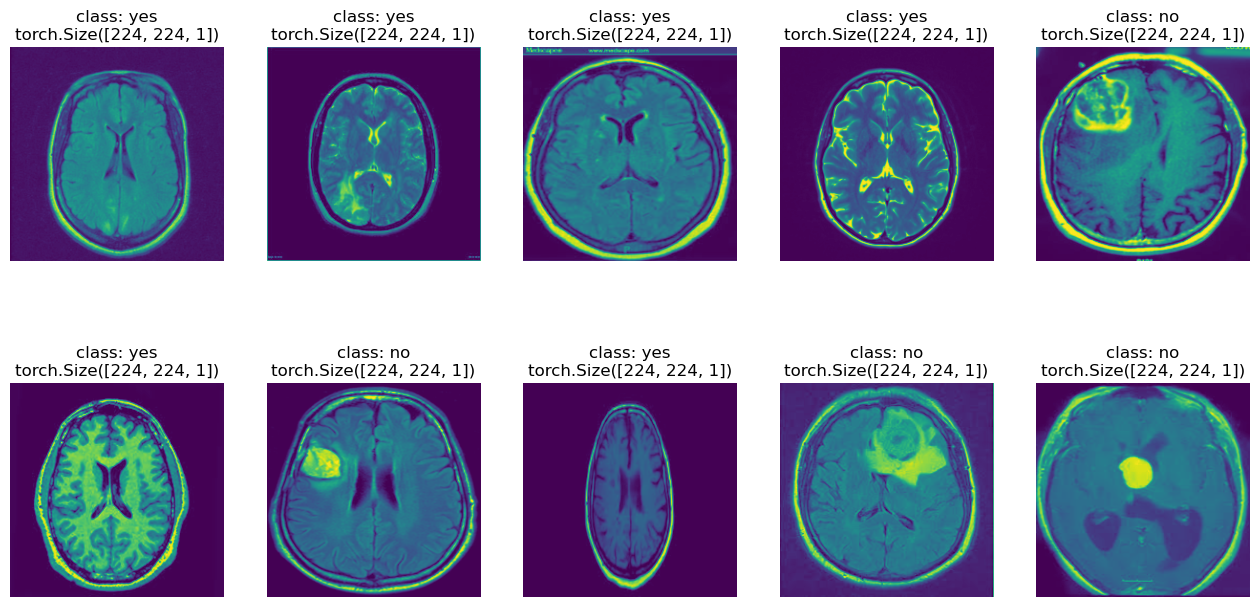

In [178]:
classes = full_dataset.classes
random_samples_idx = random.sample(range(len(full_dataset)), k=10)
print(random_samples_idx)
plt.figure(figsize=(16, 8))
for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = full_dataset[targ_sample][0], full_dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(2, 5, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
        title = f"class: {classes[targ_label]}"
        title = title + f"\n{targ_image_adjust.shape}"
    plt.title(title)

/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no/28 no.jpg
Random image path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no/28 no.jpg
Image class: 28 no
Image height: 251
Image width: 201


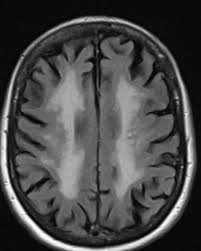

In [179]:
print(full_dataset.paths[61])
image_path = full_dataset.paths[61]
image_class = image_path.stem
img = Image.open(image_path)

# 5. Print metadata
print(f"Random image path: {image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

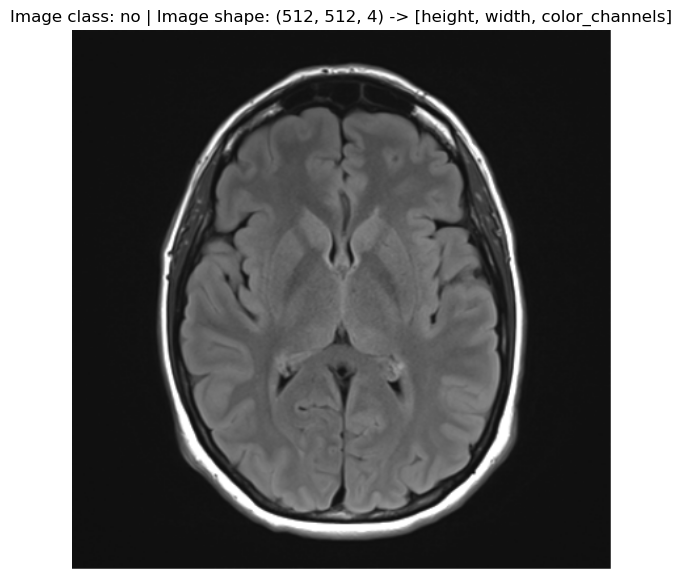

In [141]:
# Turn the image into an array
img_as_array = np.asarray(img)
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [154]:
img_as_array[:,0]

array([[ 15,  15,  15, 253],
       [ 16,  16,  16, 254],
       [ 16,  16,  16, 254],
       ...,
       [ 15,  15,  15, 254],
       [ 15,  15,  15, 254],
       [ 14,  14,  14, 191]], dtype=uint8)

In [159]:
img_as_array[:, 60, 3]

array([254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 25

In [137]:
targ_sample = 61
classes = full_dataset.classes

plt.figure(figsize=(16, 8))
targ_image, targ_label = full_dataset[targ_sample][0], full_dataset[targ_sample][1]
targ_image_adjust = targ_image.permute(1, 2, 0)
plt.imshow(targ_image_adjust)
plt.axis("off")
if classes:
    title = f"class: {classes[targ_label]}"
    title = title + f"\n{targ_image_adjust.shape}"
plt.title(title)

OLD 61 (512, 512, 4)


TypeError: Input image tensor permitted channel values are [1, 3], but found 4

<Figure size 1600x800 with 0 Axes>

In [120]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
print(f'len(train_dataset): {len(train_dataset)}, len(test_dataset): {len(test_dataset)}')
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

len(train_dataset): 136, len(test_dataset): 35
Length of train_dataloader: 17 batches of size 8
Length of test_dataloader: 5 batches of size 8
torch.Size([8, 1, 224, 224]) torch.Size([8])
torch.Size([8, 1, 224, 224]) torch.Size([8])


In [117]:
#Ideally should apply these transformations to the training dataset
#Will likely come back to see if this improves performance later on
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [91]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [112]:
import torchvision

weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)

In [113]:
layers_to_freeze = [model.conv1, model.bn1, model.layer1, model.layer2, model.layer3, model.layer4]
for layer in layers_to_freeze:
    for param in layer.parameters():
        param.requires_grad = False

In [ ]:
# model.fc = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True), 
#     torch.nn.Linear(in_features=1000, 
#                     out_features=1, # same number of output units as our number of classes
#                     bias=True),
#     ).to(device)

In [111]:
train_features_batch.shape

torch.Size([8, 1, 224, 224])

In [110]:
model(train_features_batch)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[8, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [ ]:
loss_fn = nn.BCELoss()

In [108]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [109]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    